In [53]:
from google.colab import drive # remove the cell if not using colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.linear_model import LogisticRegression
base_path = Path('/content/drive/MyDrive/Colab Notebooks/titanic.csv')

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

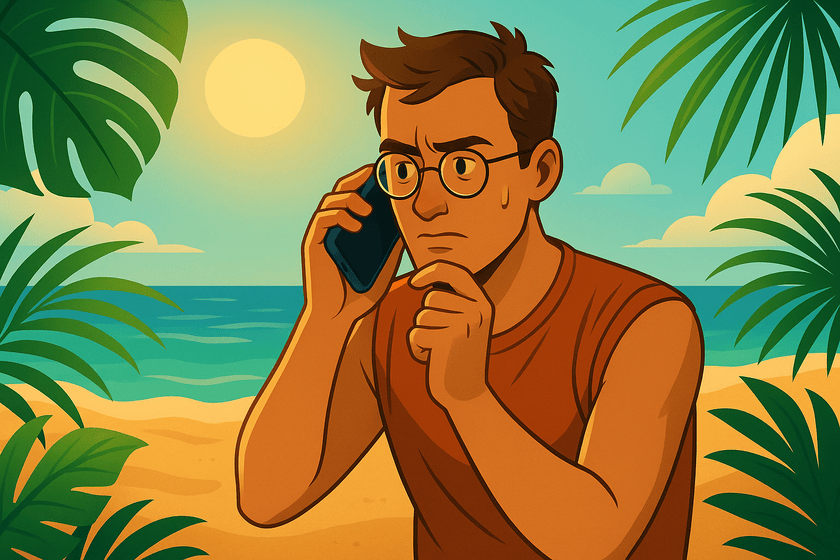

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

# **Dane i wnioski z zadania 1**

W zadania poprzedniego wykorzystam uzupełnienie brakujących danych. a także kodowanie kolumn kategorycznych. Dodatkowo skorzytam z utworzonych w tym zadaniu dodatkowych kolumn - IsMother, IsFather, FamilySize, Title, który powstał po przekształceniu kolumny Name, a także wykorzytsam przekształcenie kolumny Cabin na jej pierwsze litery. Klasa TitanicPreprocessor będzie miała metody fit oraz transform do przygotowania danych, nauki ich rozkłądu, wartości, a także pózniejszej transformacji.

In [55]:
class TitanicPreprocessor():
    def __init__(self):
        self.age_median_ = None
        self.fare_values_ = None
        self.fare_probs_ = None
        self.title_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=np.int32)
        self.cabin_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=np.int32)
        self.embarked_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=np.int32)
        self.rare_titles_ = None

    def fit(self, X, y=None):
        X = X.copy()

        self.age_median_ = X['Age'].median()

        fare_count = X['Fare'].value_counts(normalize=True)
        self.fare_values_ = fare_count.index
        self.fare_probs_ = fare_count.values

        cabins = X['Cabin'].fillna('Unknown').apply(lambda x: x if x == 'Unknown' else x[0])
        self.cabin_encoder.fit(cabins.to_frame())

        embarked = X['Embarked'].fillna('S')
        self.embarked_encoder.fit(embarked.to_frame())

        # Skracamy Name do tytułu
        titles = X['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
        title_counts = titles.value_counts()
        self.rare_titles_ = title_counts[title_counts < 3].index.tolist()
        titles = titles.replace(self.rare_titles_, 'Other')
        X['Name'] = titles  # nadpisujemy Name
        self.title_encoder.fit(X[['Name']])

        return self

    def transform(self, X):
        X = X.copy()

        X['Age'] = X['Age'].fillna(self.age_median_)

        missing_fare = X['Fare'].isna()
        X.loc[missing_fare, 'Fare'] = np.random.choice(self.fare_values_, size=missing_fare.sum(), p=self.fare_probs_)

        X['Cabin'] = X['Cabin'].fillna('Unknown').apply(lambda x: x if x=='Unknown' else x[0])
        X['Embarked'] = X['Embarked'].fillna('S')
        X['Sex'] = X['Sex'].map({'male': 1, 'female': 0})

        # Skracamy Name do tytułu i nadpisujemy
        titles = X['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
        titles = titles.replace(self.rare_titles_, 'Other')
        X['Name'] = titles

        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
        X['IsMother'] = ((X['Sex'] == 0) & (X['Parch'] > 0) & (X['Age'] > 18)).astype(int)
        X['IsFather'] = ((X['Sex'] == 1) & (X['Parch'] > 0) & (X['Age'] > 18)).astype(int)

        X = X.drop(columns=['Ticket'])

        name_ohe = self.title_encoder.transform(X[['Name']])
        embarked_ohe = self.embarked_encoder.transform(X[['Embarked']])
        cabin_ohe = self.cabin_encoder.transform(X[['Cabin']])

        X = X.drop(columns=['Name', 'Embarked', 'Cabin'])

        X_transformed = np.hstack([X.values, name_ohe, embarked_ohe, cabin_ohe])
        return X_transformed






**Wnioski z poprzedniego zadania**

Wykorzystując wykresy z poprzedniego zadania, można było zauważyć, że klasa w której podróżował pasażer miałą duży wpływ na przeżycie, a także cecha IsFather, która zwiększała szansę na przeżycie, gdzie z kolei IsMother tą szansę zaniżało. Rozmiar rodziny i typ relacji z współpasażerami (rodzice, rodzeństwo, dzieci, małżonek) też korelowało z szansą na przeżycie. Okazało się również, że tytuł pasażera jest silnie powiązany z klasą podróży pasażera. Port, w którym wsiadła dana osoba również mógł mieć wpływ na szansę na przeżycie. Płeć i wiek też były znaczącymi czynnikami. Posiadając powyższą wiedzę przejdę do budowania modelu.

# **Budowanie modeli**

Baseline

In [112]:
titanic_data=pd.read_csv(base_path)
X = titanic_data.drop('Survived', axis=1)
y = titanic_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=True)
model = DummyClassifier(strategy = 'uniform')
model.fit(X_train, y_train) # uczenie
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)


Accuracy: 0.44692737430167595
              precision    recall  f1-score   support

           0       0.58      0.43      0.50       113
           1       0.33      0.47      0.39        66

    accuracy                           0.45       179
   macro avg       0.45      0.45      0.44       179
weighted avg       0.49      0.45      0.46       179



array([[49, 64],
       [35, 31]])

Jak widać dla bazowego modelu DummySlassifier, wszytskie parametry wpadają bardzo słabo:
- Accuracy 44%
- Precision 33-58%
- Recall 43-47%


**Model z preprocessingiem i regresją logistyczną**. Jako hiperparametry będę badać C - współczynnik regularyzacji oraz solver - algorytm optymalizacji

         C     solver  Accuracy  Precision    Recall
0     0.01      lbfgs  0.793296   0.930233  0.540541
1     0.01  liblinear  0.731844   0.825000  0.445946
2     0.01       saga  0.720670   0.875000  0.378378
3     0.10      lbfgs  0.804469   0.774648  0.743243
4     0.10  liblinear  0.782123   0.761194  0.689189
5     0.10       saga  0.737430   0.745455  0.554054
6     1.00      lbfgs  0.793296   0.740260  0.770270
7     1.00  liblinear  0.793296   0.746667  0.756757
8     1.00       saga  0.743017   0.750000  0.567568
9    10.00      lbfgs  0.793296   0.746667  0.756757
10   10.00  liblinear  0.798883   0.756757  0.756757
11   10.00       saga  0.731844   0.732143  0.554054
12  100.00      lbfgs  0.804469   0.760000  0.770270
13  100.00  liblinear  0.798883   0.756757  0.756757
14  100.00       saga  0.737430   0.745455  0.554054


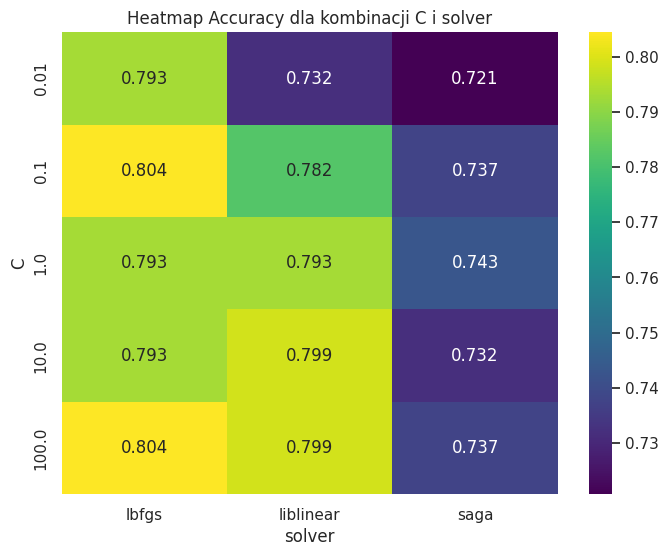

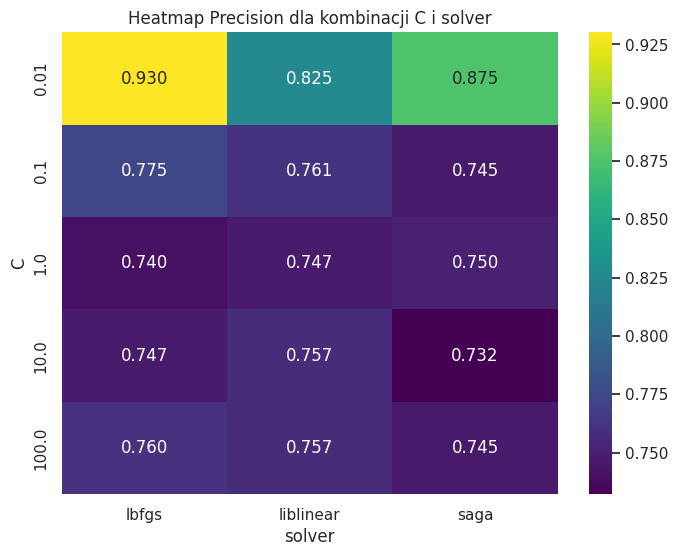

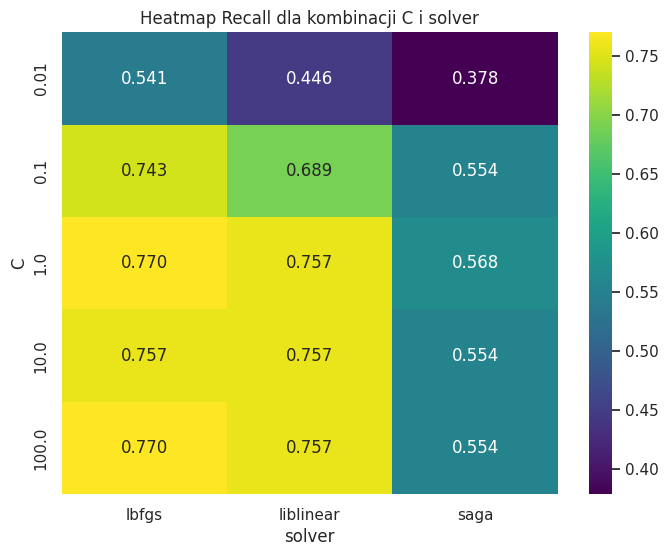

In [107]:
C_values = [0.01, 0.1, 1, 10, 100]
solvers = ['lbfgs', 'liblinear', 'saga']
results = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for C in C_values:
    for solver in solvers:
        pipeline = Pipeline([
            ('preprocessor', TitanicPreprocessor()),
            ('model', LogisticRegression(C=C, solver=solver, max_iter=10000))
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        results.append({
            "C": C,
            "solver": solver,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred)
        })

df_results = pd.DataFrame(results)
print(df_results)

# Heatmapa
for metric in ['Accuracy', 'Precision', 'Recall']:
    pivot = df_results.pivot(index="C", columns="solver", values=metric)
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"Heatmap {metric} dla kombinacji C i solver")
    plt.show()

Tutaj już wyniki są dużo lepsze:
- Accuracy 72-81%
- Precision 73-93%
- Recall 37-77%


Widać również, że wyniki znaczącą różnią się dla różnych kombinacji wartości hiperparametrów. Dla połączenia C=0.01 oraz solvr=lbfgs model daje fajne wyniki Accuracy oraz Precision (93% !), co oznacza, że większość pasażerów, których model przewidział, że przeżyją, rzeczywiście przeżyli. Jednak kuleje przy Recall (60%) co zonacza, że model 40% ocalałych pominął i źle oznaczył. Najlepszy Recall (77%) dają 3 połączenia hiperparametrów.

Dla połączenia C=0.01 oraz solvr=lbfgs sprawdzę, jakie wyniki daje model dla danych treningowych i testowych.

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', TitanicPreprocessor()),
    ('model', LogisticRegression(C=0.01, solver='lbfgs', max_iter=10000))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Metryki dla train
print("TRAIN SET")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))

# Metryki dla test
without_scaling_acc=accuracy_score(y_test, y_test_pred)
without_scaling_prec=precision_score(y_test, y_test_pred)
without_scaling_rec=recall_score(y_test, y_test_pred)
print("\nTEST SET")
print("Accuracy:", without_scaling_acc)
print("Precision:", without_scaling_prec)
print("Recall:", without_scaling_rec)

TRAIN SET
Accuracy: 0.7921348314606742
Precision: 0.8529411764705882
Recall: 0.5410447761194029

TEST SET
Accuracy: 0.8100558659217877
Precision: 0.9347826086956522
Recall: 0.581081081081081


Model nie przeuczył się i generalizuje dobrze

 **Standaryzacja**

Jako iż Logistic Regression jest algorytmem wrażliwymym na skalę, wykonam standaryzację, aby sprawdzić, czy pomoże to poprawić wyniki, jako iż w klasie TitanicPreprocessor tej standaryzacji nie wykonuje. Skorzystam z StandardScaler.

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', TitanicPreprocessor()),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(C=0.01, solver='lbfgs', max_iter=10000))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Metryki dla train
print("TRAIN SET")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))

# Metryki dla test
with_scaling_acc=accuracy_score(y_test, y_test_pred)
with_scaling_prec=precision_score(y_test, y_test_pred)
with_scaling_rec=recall_score(y_test, y_test_pred)

print("\nTEST SET")
print("Accuracy:", with_scaling_acc)
print("Precision:", with_scaling_prec)
print("Recall:", with_scaling_rec)

TRAIN SET
Accuracy: 0.8426966292134831
Precision: 0.8145161290322581
Recall: 0.753731343283582

TEST SET
Accuracy: 0.7988826815642458
Precision: 0.7794117647058824
Recall: 0.7162162162162162


**Porównanie wyników przed i po standaryzacji**

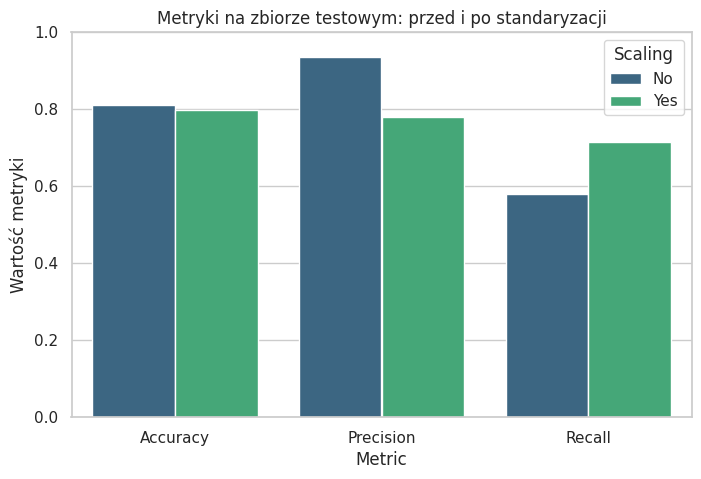

In [121]:
data_test = {
    "Metric": ["Accuracy", "Precision", "Recall"]*2,
    "Value": [
        without_scaling_acc, without_scaling_prec, without_scaling_rec,  # przed standaryzacją
        with_scaling_acc, with_scaling_prec, with_scaling_rec   # po standaryzacji
    ],
    "Scaling": ["No"]*3 + ["Yes"]*3
}

df_test = pd.DataFrame(data_test)

sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_test, x="Metric", y="Value", hue="Scaling", palette="viridis")
plt.ylim(0,1)
plt.title("Metryki na zbiorze testowym: przed i po standaryzacji")
plt.ylabel("Wartość metryki")
plt.show()

Widać, że Scaling pozytywnie wpłynął na Recall, jednak obniżył Precision

Sprawdźmy teraz inny model - **Random Forest Classifier**, sprawdzę wyniki modelu dla różnej ilości drzew. Jako hiperparametry będę traktować liczbę drzew, sprawdzając jak wpłynie ona na wyniki modelu.

Results for n_estimators=10:
Accuracy:  0.8100558659217877
Precision:  0.7857142857142857
Recall:  0.7432432432432432
Results for n_estimators=50:
Accuracy:  0.8379888268156425
Precision:  0.8169014084507042
Recall:  0.7837837837837838
Results for n_estimators=100:
Accuracy:  0.8435754189944135
Precision:  0.8382352941176471
Recall:  0.7702702702702703
Results for n_estimators=200:
Accuracy:  0.8212290502793296
Precision:  0.7916666666666666
Recall:  0.7702702702702703


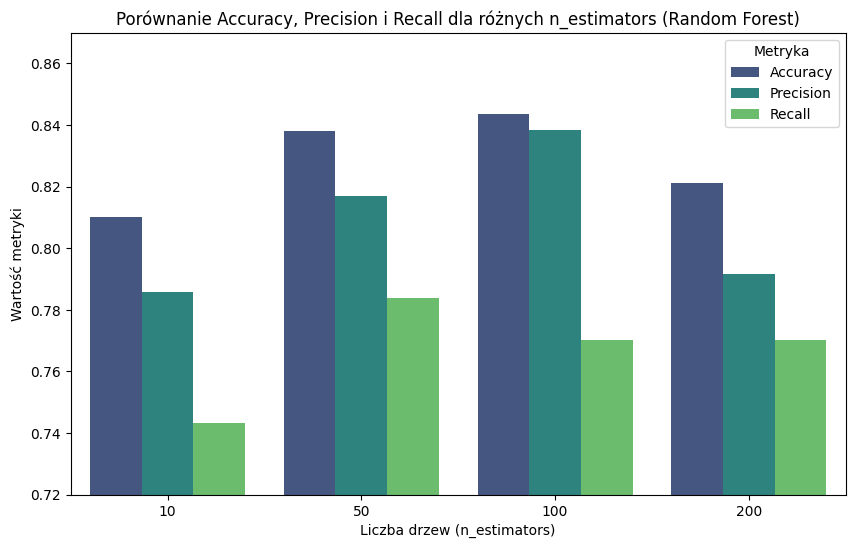

In [58]:
estimators = [10, 50, 100, 200]
results = []

for n in estimators:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline = Pipeline([
        ('preprocessor', TitanicPreprocessor()),
        ('model', RandomForestClassifier(
            n_estimators=n,
            max_depth=None,
            random_state=42
        ))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"Results for n_estimators={n}:")
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: ",acc)
    prec = precision_score(y_test, y_pred)
    print("Precision: ",prec)
    rec = recall_score(y_test, y_pred)
    print("Recall: ",rec)

    results.append({"n_estimators": n, "metric": "Accuracy", "value": acc})
    results.append({"n_estimators": n, "metric": "Precision", "value": prec})
    results.append({"n_estimators": n, "metric": "Recall", "value": rec})

df_results = pd.DataFrame(results)

# wykres słupkowy
plt.figure(figsize=(10,6))
sns.barplot(data=df_results, x="n_estimators", y="value", hue="metric", palette="viridis")
plt.title("Porównanie Accuracy, Precision i Recall dla różnych n_estimators (Random Forest)")
plt.xlabel("Liczba drzew (n_estimators)")
plt.ylabel("Wartość metryki")
plt.ylim(0.72, 0.87)
plt.legend(title="Metryka")
plt.show()


Na wykresie i po wynikach widać, że najlepsze wyniki model osiąga przy około 100 drzewach, Accuracy, Precision i Recall Score są wtedy najwyższe. Największą różnicę widać w wyniku Precision - oznacza to, że wtedy model najpoprawniej typuje, które osoby przeżyły. Dodatkowo model Random Forest wypada lepiej pod względem Accuracy i Precision niż Logistic Regression, natomiast Recall jest wyższe dla regresji logistycznej.

- Accuracy 81-84%
- Precision 78-83%
- Recall 74-78%

Dla przypuszczalnie najlepszej liczby drzew=100, porównam wyniki dla train i test set.

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', TitanicPreprocessor()),
    ('model', RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            random_state=42
        ))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Metryki dla train
print("TRAIN SET")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))

# Metryki dla test
print("\nTEST SET")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))

TRAIN SET
Accuracy: 0.9915730337078652
Precision: 0.9888059701492538
Recall: 0.9888059701492538

TEST SET
Accuracy: 0.8324022346368715
Precision: 0.8235294117647058
Recall: 0.7567567567567568


Model bardzo dobrze zapamiętał dane treningowe (wyniki bliskie 1), ale nie generalizuje dobrze na nowych danyxh, stąd znacznie niższe wyniki na teście.
Prawdopodobnie doszło do overfittingu.

Teraz sprawdzę, jak z klasyfikacją poradzi sobie model **XGBoost**. Jako hiperparametry będę traktować liczbę drzew, sprawdzając jak wpłynie ona na wyniki modelu.

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:09:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:09:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:09:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results for n_estimators=10:
Accuracy:  0.8100558659217877
Precision:  0.8333333333333334
Recall:  0.6756756756756757
Results for n_estimators=50:
Accuracy:  0.8268156424581006
Precision:  0.8115942028985508
Recall:  0.7567567567567568
Results for n_estimators=100:
Accuracy:  0.8100558659217877
Precision:  0.7857142857142857
Recall:  0.7432432432432432
Results for n_estimators=200:
Accuracy:  0.8044692737430168
Precision:  0.7671232876712328
Recall:  0.7567567567567568


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:09:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


<Figure size 1000x600 with 0 Axes>

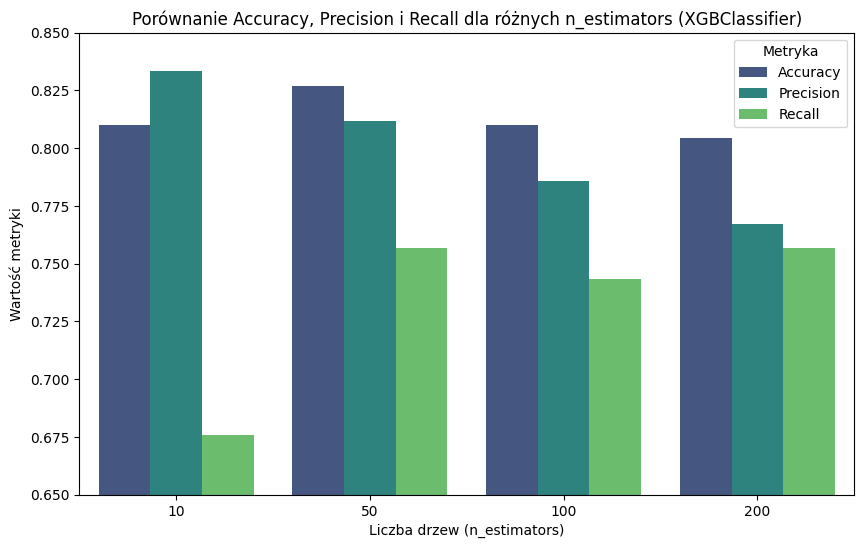

In [70]:
estimators = [10, 50, 100, 200]
results = []
for n in estimators:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline = Pipeline([
        ('preprocessor', TitanicPreprocessor()),
        ('model', XGBClassifier(
            n_estimators=n,
            max_depth=3,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42
        ))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"Results for n_estimators={n}:")
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: ",acc)
    prec = precision_score(y_test, y_pred)
    print("Precision: ",prec)
    rec = recall_score(y_test, y_pred)
    print("Recall: ",rec)

    results.append({"n_estimators": n, "metric": "Accuracy", "value": acc})
    results.append({"n_estimators": n, "metric": "Precision", "value": prec})
    results.append({"n_estimators": n, "metric": "Recall", "value": rec})

# Wykresy
plt.figure(figsize=(10,6))
df_results = pd.DataFrame(results)

# wykres słupkowy
plt.figure(figsize=(10,6))
sns.barplot(data=df_results, x="n_estimators", y="value", hue="metric", palette="viridis")
plt.title("Porównanie Accuracy, Precision i Recall dla różnych n_estimators (XGBClassifier)")
plt.xlabel("Liczba drzew (n_estimators)")
plt.ylabel("Wartość metryki")
plt.ylim(0.65, 0.85)
plt.legend(title="Metryka")
plt.show()

Tutaj już widać, iż poszczególne metryki mają najlepsze wyniki dla różnej liczby drzew. Accuracy wypasda najlepiej dla 50, Precision dla 10, a Recall dla 200. Natomiast dla 10 drzew Recall jest zdecydowanie niższy niż dla innych prób. Widać, że nawet najlepsze wyniki wszytskich metryk w modelu XGBClassifier są niższe niż dla Random Forest Classifier.

- Accuracy 80-82%
- Precision 77-83%
- Recall 68-76%

Dla liczby drzew 50 sprawdzę jak wypadają wyniki na zbiorze testowym i treningowym.

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', TitanicPreprocessor()),
    ('model', XGBClassifier(
            n_estimators=50,
            max_depth=3,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42
        ))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Metryki dla train
print("TRAIN SET")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))

# Metryki dla test
print("\nTEST SET")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:02:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


TRAIN SET
Accuracy: 0.875
Precision: 0.8942731277533039
Recall: 0.7574626865671642

TEST SET
Accuracy: 0.8156424581005587
Precision: 0.8059701492537313
Recall: 0.7297297297297297


Model nie jest przeuczony. Różnica między train a test nie jest duża, więc model generalizuje dobrze.
Precision i recall są dość zbalansowane, co oznacza, że model nie faworyzuje ani fałszywych alarmów, ani braków wykrycia przypadków pozytywnych.

Następnie przetestuje **metodę najbliższych sąsiadów - KNN**. Jako hipermarapetry będe zmieniać liczbę sąsiadów oraz metrykę odległości.

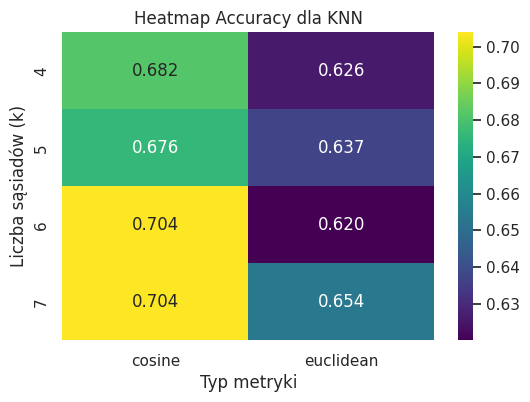

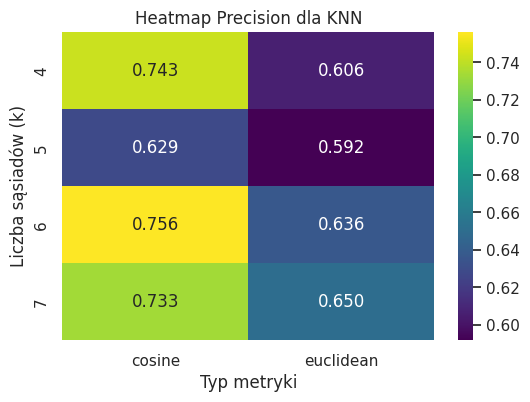

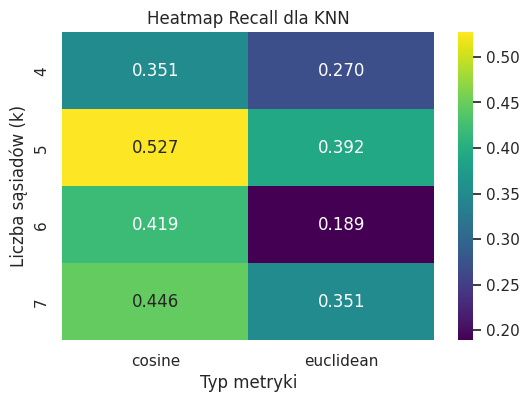

In [102]:
n_neighbors = [ 4, 5, 6, 7]
metrics = ['euclidean', 'cosine']
results = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for metric in metrics:
    for k in n_neighbors:
        pipeline = Pipeline([
            ('preprocessor', TitanicPreprocessor()),
            ('model', KNeighborsClassifier(n_neighbors=k, metric=metric))
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)

        results.append({
            "metric_type": metric,
            "k_neighbors": k,
            "Accuracy": accuracy,
            "Precision": prec,
            "Recall": rec
        })

df_results = pd.DataFrame(results)
sns.set(style="whitegrid")

metrics_to_plot = ['Accuracy', 'Precision', 'Recall']

for metric in metrics_to_plot:
    pivot = df_results.pivot(index='k_neighbors', columns='metric_type', values=metric)
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"Heatmap {metric} dla KNN")
    plt.xlabel("Typ metryki")
    plt.ylabel("Liczba sąsiadów (k)")
    plt.show()

Jak widać, dla róznej liczby sąsiadów i różnej metryki odległości, wyniki Accuracy, Recall i Precision różnią się od sibie, jednak w każdym wariancie wypadają gorzej niż poprzednie modele, zwłaszcza Recall jest wyjątkowo niski.Jednak we wszystkich przypadkach metryka odległości Cosine wypadła lepiej niż Euclidean.

Sprawdzę różnicę pomiędzy wynikami dla test i train set dla n_neighbors=6 i metric='cosine'

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', TitanicPreprocessor()),
    ('model', KNeighborsClassifier(n_neighbors=6, metric='cosine'))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Metryki dla train
print("TRAIN SET")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))

without_scaling_acc_knn=accuracy_score(y_test, y_test_pred)
without_scaling_prec_knn=precision_score(y_test, y_test_pred)
without_scaling_rec_knn=recall_score(y_test, y_test_pred)
# Metryki dla test
print("TEST SET")
print("Accuracy:", without_scaling_acc_knn)
print("Precision:", without_scaling_prec_knn)
print("Recall:", without_scaling_rec_knn)

TRAIN SET
Accuracy: 0.7401685393258427
Precision: 0.7577639751552795
Recall: 0.4552238805970149

TEST SET
Accuracy: 0.6703910614525139
Precision: 0.6829268292682927
Recall: 0.3783783783783784


KNN również jest wrażliwy na skalę, dlatego tuttaj również dla wybranych wartości hiperparametrów, sprawdzę czy stadaryzacja poprawi wyniki.

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
  ('preprocessor', TitanicPreprocessor()),
  ('scaler', StandardScaler()),
  ('model', KNeighborsClassifier(n_neighbors=6, metric='cosine'))
  ])

pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

#Metryki dla train
print("TRAIN SET")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))

with_scaling_acc_knn=accuracy_score(y_test, y_pred)
with_scaling_prec_knn=precision_score(y_test, y_pred)
with_scaling_rec_knn=recall_score(y_test, y_pred)
# Metryki dla test
print("TEST SET")
print("Accuracy:", with_scaling_acc_knn)
print("Precision:", with_scaling_prec_knn)
print("Recall:", with_scaling_rec_knn)





TRAIN SET
Accuracy: 0.851123595505618
Precision: 0.8970588235294118
Recall: 0.6828358208955224
TEST SET
Accuracy: 0.8156424581005587
Precision: 0.8253968253968254
Recall: 0.7027027027027027


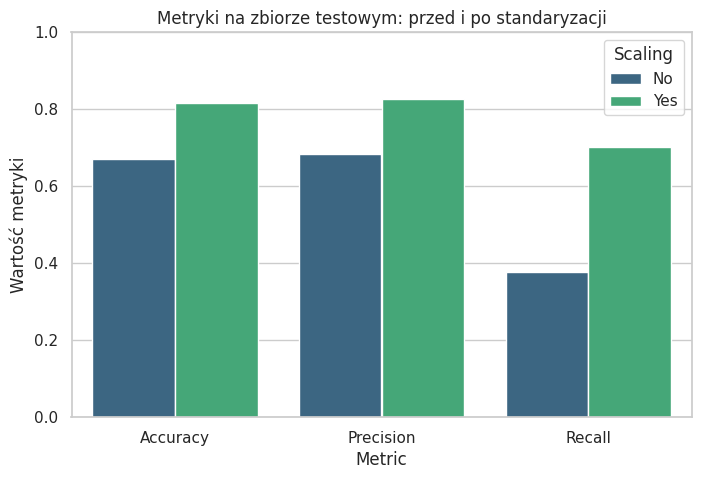

In [126]:
data_test = {
    "Metric": ["Accuracy", "Precision", "Recall"]*2,
    "Value": [
        without_scaling_acc_knn, without_scaling_prec_knn, without_scaling_rec_knn,  # przed standaryzacją
        with_scaling_acc_knn, with_scaling_prec_knn, with_scaling_rec_knn   # po standaryzacji
    ],
    "Scaling": ["No"]*3 + ["Yes"]*3
}

df_test = pd.DataFrame(data_test)

sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_test, x="Metric", y="Value", hue="Scaling", palette="viridis")
plt.ylim(0,1)
plt.title("Metryki na zbiorze testowym: przed i po standaryzacji")
plt.ylabel("Wartość metryki")
plt.show()

Widać, że po standaryzacji wyniki znacząco się polepszyły, dla każdej metryki, w szczególności Recall, który wzrósł prawie dwukrotnie.

***Podsumowanie***

Dla Titanic dataset bardo dobrze sprawdzzają się modele wykorzystujące drzewa decyzyjne, jednak lepszy okazał się model XGBClassifier, który w przeciwiństwie do Random Tree Regressor nie przeuczył się. Regresja logistyczna również okazała się dobrym wyborem, jednak wypadła nieco gorzej od dzrew decyzyjnych, mimo wysokiego wyniku Precision. Metoda najblższych sąsiadów dała w porządku wyniki dopiero po przeprowadzeniu standaryzacji. Wszystkie testy pokazały, że dobór wartości hiperparametrów ma ogromny wpływ na naukę i wyniki modelu.